In [2]:
from functions import *

# 1. Creating Datasets for Each Industries

## 1.1. Converting Submissions into Dataset

Assuming that you have downloaded the Submissions bulk folder as 'sub' in your directory, run following code to convert them into a merged dataset. The dataset will include given necessary columns including: CIK, Type, SIC, Description, Name, Ticker, and Exchange.

In [4]:
data_list = []
for file_name in os.listdir('companyfacts'):
    file_path = os.path.join('sub',file_name)
    if file_name.endswith('.json'):
        try:
            with open(file_path, 'r') as file:
                # Load the content of the JSON file
                json_data = json.load(file)
                # Extract the desired data
                data = {'CIK': json_data['cik'],
                        'Type':json_data['entityType'], 
                        'SIC': json_data['sic'],
                        'Description':json_data['sicDescription'], 
                        'Name': json_data['name'],
                        'Ticker':json_data['tickers'], 
                        'Exchange':json_data['exchanges']}
                data_list.append(data)
        except (KeyError, json.JSONDecodeError):
            continue  # Skip the file if an error occurs
pd.DataFrame(data_list).to_csv('_Submissions.csv',index=False)

In [6]:
sub = pd.read_csv('_Submissions.csv')

In [17]:
sub

,CIK,Type,SIC,Description,Name,Ticker,Exchange
0,743870,operating,6500.0,Real Estate,RANCON REALTY FUND IV,[],[]
1,815097,operating,4400.0,Water Transportation,CARNIVAL CORP,['CCL'],['NYSE']
2,1466739,operating,7361.0,Services-Employment Agencies,Next Galaxy Corp.,[],[]
3,1841661,operating,6770.0,Blank Checks,AF Acquisition Corp.,[],[]
4,1831099,other,7370.0,"Services-Computer Programming, Data Processing...",AFR Inc.,[],[]
...,...,...,...,...,...,...,...
17687,899749,operating,6798.0,Real Estate Investment Trusts,"HRTI, LLC",[],[]
17688,1524083,operating,7374.0,Services-Computer Processing & Data Preparation,ChatChing Inc.,[],[]
17689,1381668,operating,6035.0,"Savings Institution, Federally Chartered",TFS Financial CORP,['TFSL'],['Nasdaq']
17690,1354772,operating,6035.0,"Savings Institution, Federally Chartered",NORTHEAST COMMUNITY BANCORP INC,[],[]


## 1.2. Choosing Industries

### A. Creating Dataset for Industries

In [80]:
count = sub['SIC'].value_counts().reset_index()
desc = sub[['SIC','Description']].drop_duplicates()
pd.merge(count, desc, on='SIC').sort_values(by='count',ascending=False).to_csv('_Industries.csv',index=False,mode='w')

In [3]:
sic = pd.read_csv('_Industries.csv')

In [4]:
sic

,SIC,count,Description
0,2834.0,1087,Pharmaceutical Preparations
1,6770.0,1045,Blank Checks
2,7372.0,653,Services-Prepackaged Software
3,6798.0,502,Real Estate Investment Trusts
4,1311.0,441,Crude Petroleum & Natural Gas
...,...,...,...
429,2253.0,1,Knit Outerwear Mills
430,5064.0,1,"Wholesale-Electrical Appliances, Tv & Radio Sets"
431,3260.0,1,Pottery & Related Products
432,4013.0,1,Railroad Switching & Terminal Establishments


In [7]:
print(f"{sic['count'].sum()}: Number of companies included in the industries dataset.")
print(f"{len(sub[sub['Description'].isna()])}: Number of companies with unidentified SIC")

15684: Number of companies included in the industries dataset.
2011: Number of companies with unidentified SIC


### B. Plotting & Choosing Top Industries

<Axes: >

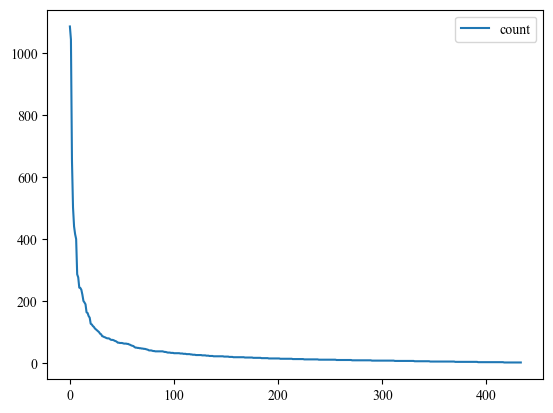

In [20]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
sic.plot(kind='line',y='count')

Because the industry has power-law distribution (there are small number of common industries with most of the companies and large number of industries with small number of companies), it is preferred to select the most populated industries because the industries with less companies (e.g., 1 or 10) don't have enough data to train machine learning model on. Therefore, industries that include more than 100 companies are chosen to be trained for the model.

In [23]:
sic_top = sic[sic['count']>100]

In [33]:
chosen_sic = sic_top['SIC']

Following SICs will be used in iterating through companyfacts to convert the JSON Files:

In [35]:
chosen_sic

0     2834.0
1     6770.0
2     7372.0
3     6798.0
4     1311.0
5     6022.0
6     7389.0
7     2836.0
8     3841.0
9     3674.0
10    7374.0
11    1000.0
12    6021.0
13    6500.0
14    6035.0
15    1040.0
16    6221.0
17    7370.0
18    4911.0
19    6199.0
20    8742.0
21    5812.0
22    8200.0
23    7371.0
24    7373.0
25    6331.0
26    4813.0
27    2860.0
Name: SIC, dtype: float64

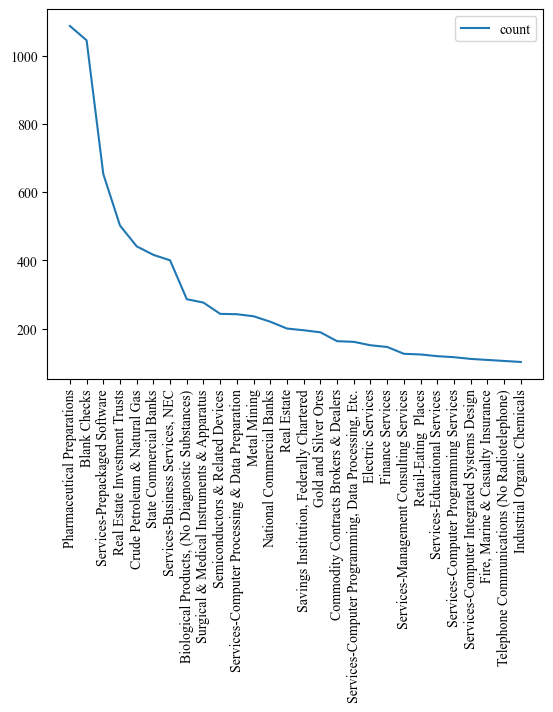

In [28]:
import matplotlib.pyplot as plt

# Assuming sic_top is a DataFrame with 'Description' and 'count' columns
plt.rcParams["font.family"] = "Times New Roman"

# Plotting the data
sic_top.plot(kind='line', y='count')

# Ensure all x-axis labels are displayed and rotated
plt.xticks(ticks=range(len(sic_top['Description'])), labels=sic_top['Description'], rotation=90)

# Display the plot
plt.show()

## 1.3. Creating Datasets for Each Chosen Industries

### A. Create List of CIKs for Each Industry SICs

In [37]:
sub = pd.read_csv('_Submissions.csv')

In [45]:
sic_dict = {}
for i in chosen_sic:
    sic_dict[i] = sub[sub['SIC'] == i]['CIK'].tolist()

In [103]:
len(sic_dict[4813])

105

### B. Convert Each Industry to Merged Datasets

In [72]:
for i in sic_dict:
    df = convertor_multiple(cik_to_file(sic_dict[i]))
    df.to_csv(f'datasets/df_{i}.csv',mode='w',index=False)

KeyboardInterrupt: 

In [134]:
import os
import pandas as pd

# Directory containing your CSV files
folder_path = 'datasets/'

# Initialize lists to store file properties
file_names = []
row_sizes = []
column_sizes = []
file_sizes = []
num_companies = []

# Iterate through each file in the directory
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # Ensure it's a CSV file
        file_path = os.path.join(folder_path, file_name)
        
        # Get file size
        file_size_bytes = os.path.getsize(file_path)
        file_size = math.ceil(file_size_bytes / (1024 * 1024))
        file_sizes.append(file_size)
        
        # Read the CSV file to get row and column sizes
        df = pd.read_csv(file_path)
        num_rows, num_cols = df.shape
        row_sizes.append(num_rows)
        column_sizes.append(num_cols)
        num_companies.append(len(df['CIK'].unique()))
        
        # Store the file name
        file_names.append(file_name)
        
# Create a DataFrame with the collected data
data = {
    'File Name': file_names,
    'Companies': num_companies,
    'Row Size': row_sizes,
    'Column Size': column_sizes,
    'File Size MB': file_sizes
}

df = pd.DataFrame(data)

In [135]:
df

,File Name,Companies,Row Size,Column Size,File Size MB
0,df_2836.csv,266,9836,3901,43
1,df_6500.csv,190,6444,4426,31
2,df_2834.csv,1024,39825,5746,242
3,df_1040.csv,134,4842,3198,17
4,df_5812.csv,123,4819,3719,21
5,df_8200.csv,113,3427,3493,14
6,df_6199.csv,132,4368,4486,22
7,df_6770.csv,1043,14725,3118,48
8,df_6798.csv,497,22472,5920,146
9,df_2860.csv,99,3882,3715,17


In [136]:
df.to_csv('datasets_EDA.csv',mode='w',index=False)